In [1]:
import numpy as np
import pandas as pd

# data = pd.read_csv('../Documents/data_set/New_Data_Set/1.14MHz Data/Result/Features/Overall/car_human_pillar_wall_overall.csv')
car_data = pd.read_csv('../../data/features/2MHz/car.csv')
human_data = pd.read_csv('../../data/features/2MHz/human.csv')
pillar_data = pd.read_csv('../../data/features/2MHz/pillar.csv')
wall_data = pd.read_csv('../../data/features/1MHz/wall.csv')

In [2]:
human = human_data.loc[human_data['type'] == 'HUMAN'].iloc[:,4:]
car = car_data.loc[car_data['type'] == 'CAR'].iloc[:,4:]
pillar = pillar_data.loc[pillar_data['type'] == 'PILLAR'].iloc[:,4:]
wall = wall_data.loc[wall_data['type'] == 'WALL'].iloc[:,4:]

In [4]:
human_label = ['HUMAN']*human.shape[0]
car_label = ['CAR']*car.shape[0]
wall_label = ['WALL']*wall.shape[0]
pillar_label = ['PILLAR']*pillar.shape[0]
non_human_label = ['NON_HUMAN']*(car.shape[0] + pillar.shape[0])

label = human_label + non_human_label
from sklearn.model_selection import train_test_split

data = human.values.tolist() + car.values.tolist() + pillar.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [5]:
from sklearn import preprocessing
def custom_normalization(X_set):
    new_X_set = []
    for X in X_set:
        min = np.min(X)
        max = np.max(X)
        value = max - min
        data_set = []
        for data in X:
           data_set.append(((data - min) / value) + 0)
        new_X_set.append(data_set)
    return new_X_set

normalized_X_Human_Non_Human_train = custom_normalization(X_train)
normalized_X_Human_Non_Human_test = custom_normalization(X_test)

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix

def create_confusion_matrix(y_test, result):
    cm = confusion_matrix(y_test, result)
    import seaborn as sns
    import matplotlib.pyplot as plt     
    sum = np.sum(cm, axis=1)
    score = accuracy_score(y_test, result)
    print(score)
    labels = ['HUMAN', 'NON_HUMAN']
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision_CLASS_A = round(precision_score(y_test, result, average='binary',pos_label=labels[0]),2)
    precision_CLASS_B = round(precision_score(y_test, result, average='binary',pos_label=labels[1]),2)
    recall_CLASS_A = round(recall_score(y_test, result, average='binary',pos_label=labels[0]),2)
    recall_CLASS_B = round(recall_score(y_test, result, average='binary',pos_label=labels[1]),2)
    f1_CLASS_A = round(f1_score(y_test, result, average='binary',pos_label=labels[0]),2)
    f1_CLASS_B = round(f1_score(y_test, result, average='binary',pos_label=labels[1]),2)
    f1_average = round((f1_CLASS_A + f1_CLASS_B)/2, 2);
    print('Precision: Class A',precision_CLASS_A)
    print('Precision: Class B',precision_CLASS_B)
    print('Recall: Class A',recall_CLASS_A)
    print('Recall: Class B',recall_CLASS_B)
    print('F1-Score: Class A',f1_CLASS_A)
    print('F1-Score: Class B',f1_CLASS_B)
    print('Average F1-score:', f1_average)
        
    cm_new = np.append(cm[0], recall_CLASS_A)
    cm_new2 = np.append(cm[1], recall_CLASS_B)
    cm_new3 = np.array([precision_CLASS_A, precision_CLASS_B, score])
    cm = np.array([cm_new,cm_new2,cm_new3])
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, ax = ax,linewidths=.5,fmt='g',cmap="Reds"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('CNN Confusion Matrix'); 
    counter = 0
    for i in range(0,2):
        for j in range(0,3):
            percentage = cm[i][j]/sum[i]
            t = ax.texts[counter]
            if j == 2:
                t.set_text(str(cm[i][j]))
            else:
                t.set_text(str(cm[i][j]) + '\n' + str(round(percentage*100,2)) + " %")
            counter = counter + 1
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels);

0.9513086989992302
Precision: Class A 0.96
Precision: Class B 0.95
Recall: Class A 0.93
Recall: Class B 0.97
F1-Score: Class A 0.94
F1-Score: Class B 0.96
Average F1-score: 0.95


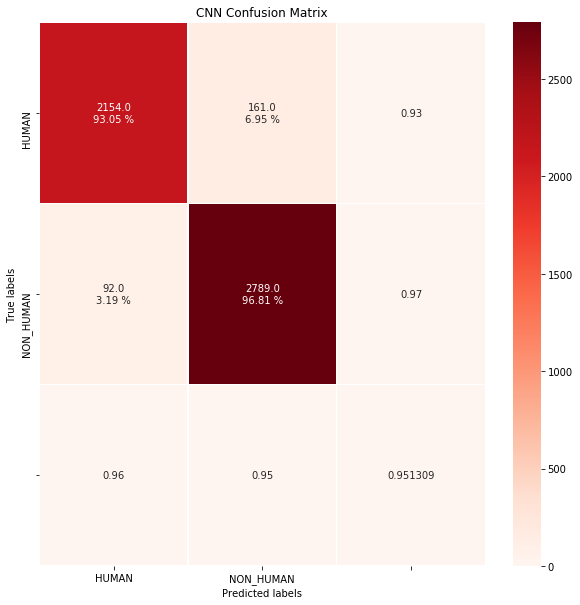

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier


clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50), random_state=12)
clf.fit(normalized_X_Human_Non_Human_train, y_train)
result = clf.predict(normalized_X_Human_Non_Human_test)
create_confusion_matrix(y_test, result)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
X, y = make_moons()
mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.882 (+/-0.008) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.936 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.883 (+/-0.008) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.937 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.883 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.946 (+/-0.023) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver

/Users/anujjoshi/miniconda3/envs/uni_project/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [12]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 100, 50),
 'learning_rate': 'adaptive',
 'solver': 'adam'}